This notebook was made with reference to this tutorial: https://github.com/bentrevett/pytorch-sentiment-analysis

## Details on notebook

In this notebook, I implement the LSTM network on the pre-processed dataset, using PyTorch and TorchText. Before implementing the neural network and passing the data in, I further prepared the text data to turn it into a form that the LSTM model can read.

Steps I took:
1. Tokenizing data
2. Splitting of data into train, test and validation
3. Creating a vocabulary
4. Turning text into numbers
5. Creating the dataloaders

In [2]:
%pip install datasets

Imported modules

In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import tqdm

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codespace/.python/current/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/codespace/.python/current/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following

Setting the seed to ensure results can be reproduced

In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

<b>Loading the data</b>

In [4]:
# load the csv files using load_dataset() function from huggingface
# we use ML_train.csv and ML_TEST..csv because the LSTM also requires similar preprocessing of text data
train_data = datasets.load_dataset("csv", data_files="data/ML/ML_train.csv", split="train")
test_data = datasets.load_dataset("csv", data_files="data/ML/ML_test.csv", split="train")

Generating train split: 160000 examples [00:00, 738055.35 examples/s]
Generating train split: 40000 examples [00:00, 758127.77 examples/s]


<b>Tokenization of text</b>

Here, we break down the text into individual <i>tokens</i>

The get_tokenizer function also supports other tokenizers, such as ones provided by spaCy and nltk

In [5]:
# initialize a tokenizer
tokenizer = get_tokenizer("basic_english")

In [6]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [7]:
max_length = 100 # from our EDA file, we see that the length of each text does not exceed 100

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map: 100%|██████████| 40000/40000 [00:01<00:00, 20776.43 examples/s]


<b>Creating a validation set</b>

We create a validation set from our train data. We will evaluate our model using this validation data.

In [8]:
test_size = 0.1

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [9]:
print(f"Length of training data: {len(train_data)}")
print(f"Length of validation data: {len(valid_data)}")
print(f"Length of test data: {len(test_data)}")

Length of training data: 144000
Length of validation data: 16000
Length of test data: 40000


<b>Creating a vocabulary</b>

Next, we have to build a vocabulary. This is look-up table where every unique token in the dataset has a corresponding index (an integer). This is because ML models cannot operate on strings, only numerical values.

One issue with creating a vocabulary using every single word in the dataset is that there are usually a considerable amount of unique tokens. In this notebook, I construct the vocaulbulary using only tokens that appear a minimum amount of times in the dataset. Tokens that appear less than the specified amount of times will be replaced with the `<unk>` token.

We use the `build_vocab_from_iterator` function from `torchtext.vocab` to create our vocabulary, specifying the `min_freq` (the minimum amount of times a token should appear to be added to the vocabulary) and `special_tokens` (tokens which should be appended to the start of the vocabulary, even if they don't appear `min_freq` times in the dataset).

The other special token we use is `<pad>`, it is used for padding sentences.

When we feed sentences into our model, we pass a batch of sentences, i.e. more than one, at the same time. Passing a batch of sentences is preferred to passing sentences one at a time as it allows our model to perform computation on all sentences within a batch in paralle, thus speeding up the time taken to train and evaluate our model. All sentences within a batch need to be the same length (in terms of the number of tokens). Thus, to ensure each sentence is the same length, any shorter than the longest sentence need to have padding tokens appended to the end of them.

In [10]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"] # <pad> to pad sequences when they are not long enough

vocab = build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

We can view the tokens in our vocabulary using the `get_itos()` method, which returns a list of strings (tokens), and the index of each token in the list is the index of the token in our vocabulary.

In [11]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

By default, a vocabulary created by torchtext will throw an error if you attempt to obtain the index of a token which is not in the vocabulary, i.e. `vocab["some_token"]` will throw an error.

We need to explicity tell the vocabulary which token to return if we pass a token not in the vocabulary. We do this using the set_default_index method, passing in the index we wish it to return. Here, we pass the index of the unknown token.

In [12]:
vocab.set_default_index(unk_index) # so that if some words are not in the vocabulary, we will use <unk> instead of that unknown word

<b>Numericalizing data</b>

We need to convert the tokens within our dataset into indices. The function below helps us do that.

In [13]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"]) # The lookup_indices() method looks up a list of tokens in our vocabulary
    return {"ids": ids}

In [14]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/144000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [15]:
train_data = train_data.with_format(type="torch", columns=["ids", "humor", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "humor", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "humor", "length"])

In [16]:
train_data[0]

{'humor': tensor(False),
 'length': tensor(8),
 'ids': tensor([2549, 3832, 1363, 3916,  654,  564,  270,  357])}

In [17]:
# function to pad indices and do batching

def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["humor"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "humor": batch_label}
        return batch

    return collate_fn

In [18]:
# use this custom collate function to format the batch correctly.
# Since there are variable-length sequences that need to be padded to the same length within each batch.

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [19]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

Defining a class for the LSTM

In [20]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [21]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = len(train_data.unique("humor"))
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [22]:
# number of trainable parameters for the LSTM network
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 8,224,802 trainable parameters


In [23]:
# function to initialize weight of the LSTM network
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [24]:
model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(15380, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=600, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:55, 5.24MB/s]                            
100%|█████████▉| 2196016/2196017 [04:57<00:00, 7392.44it/s]


In [26]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [27]:
model.embedding.weight.data = pretrained_embedding

In [28]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
criterion = nn.CrossEntropyLoss()

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [31]:
model = model.to(device)
criterion = criterion.to(device)

In [32]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [33]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["humor"].type(torch.LongTensor).to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [34]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["humor"].type(torch.LongTensor).to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [35]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 32/32 [00:00<00:00, 35.69it/s]


epoch: 0
train_loss: 0.326, train_acc: 0.858
valid_loss: 0.236, valid_acc: 0.904


evaluating...: 100%|██████████| 32/32 [00:00<00:00, 35.38it/s]


epoch: 1
train_loss: 0.242, train_acc: 0.899
valid_loss: 0.215, valid_acc: 0.912


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 24.23it/s]


epoch: 2
train_loss: 0.212, train_acc: 0.912
valid_loss: 0.200, valid_acc: 0.920


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 28.83it/s]


epoch: 3
train_loss: 0.194, train_acc: 0.919
valid_loss: 0.192, valid_acc: 0.923


evaluating...: 100%|██████████| 32/32 [00:00<00:00, 34.61it/s]


epoch: 4
train_loss: 0.179, train_acc: 0.927
valid_loss: 0.189, valid_acc: 0.925


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 28.66it/s]


epoch: 5
train_loss: 0.166, train_acc: 0.933
valid_loss: 0.187, valid_acc: 0.926


evaluating...: 100%|██████████| 32/32 [00:01<00:00, 24.30it/s]


epoch: 6
train_loss: 0.154, train_acc: 0.938
valid_loss: 0.189, valid_acc: 0.926


evaluating...: 100%|██████████| 32/32 [00:00<00:00, 35.65it/s]


epoch: 7
train_loss: 0.146, train_acc: 0.941
valid_loss: 0.190, valid_acc: 0.928


evaluating...: 100%|██████████| 32/32 [00:00<00:00, 35.50it/s]


epoch: 8
train_loss: 0.135, train_acc: 0.945
valid_loss: 0.188, valid_acc: 0.928


evaluating...: 100%|██████████| 32/32 [00:00<00:00, 35.90it/s]

epoch: 9
train_loss: 0.128, train_acc: 0.948
valid_loss: 0.191, valid_acc: 0.930


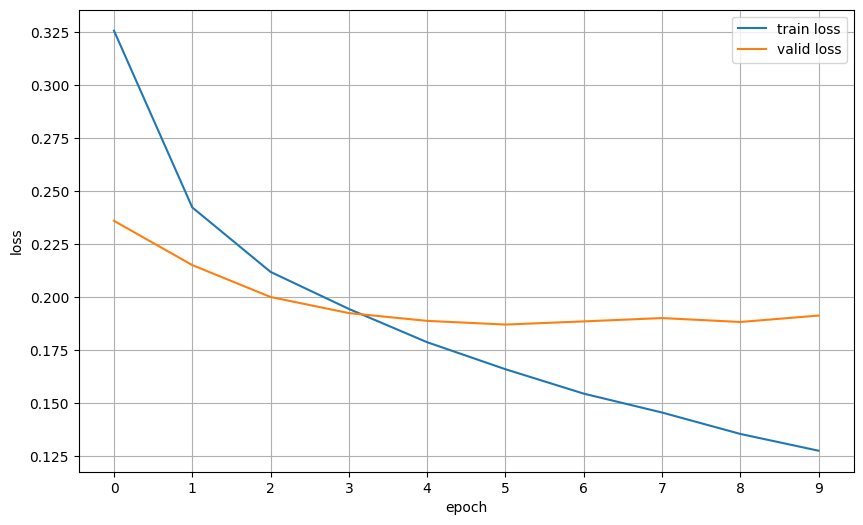

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

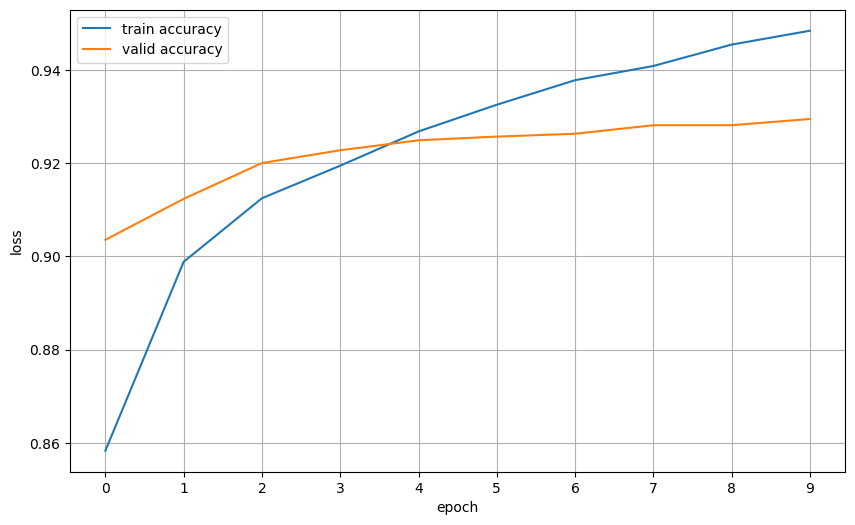

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [38]:
model.load_state_dict(torch.load("lstm.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 79/79 [00:03<00:00, 23.94it/s]


In [39]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.191, test_acc: 0.924


Function to help predict the sentiment

In [40]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    length = torch.LongTensor([len(ids)])
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor, length).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [41]:
text = "how much do pirates pay for corn? a buck an ear!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9996237754821777)

In [42]:
text = "nbc reporter rescues 2 dolphins beached by irma"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9997356534004211)